# Importing the necessary libraries

In [ ]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Mounting Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the dataset

df_unclean = pd.read_csv('/content/drive/MyDrive/Capstone/forestfires.csv')
df_unclean.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Getting a description of the dataset

In [ ]:
# Getting a description of the dataset

df_unclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [ ]:
# Checking the shape of the dataset

print("The shape of the dataset is:", df_unclean.shape)

The shape of the dataset is: (517, 13)


# Pre-processing the data

In [ ]:
# Checking for NA values

print("The number of NA values in the dataset is:", df_unclean.isna().sum().sum())

The number of NA values in the dataset is: 0


In [ ]:
# Checking for skewness in the predictor variable

df_unclean.skew(axis = 0)

<ipython-input-7-8eb90570338d>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_unclean.skew(axis = 0)


X        0.036246
Y        0.417296
FFMC    -6.575606
DMC      0.547498
DC      -1.100445
ISI      2.536325
temp    -0.331172
RH       0.862904
wind     0.571001
rain    19.816344
area    12.846934
dtype: float64

In [ ]:
# Correcting the skewness in the response variable

df = df_unclean.copy()
df['area'] = np.log(df['area'] + 1)
print("Previous skew of area:", df_unclean['area'].skew())
print("Current skew of area:", df['area'].skew())

Previous skew of area: 12.846933533934868
Current skew of area: 1.2178376559535011


In [ ]:
# Exploring the dataset


In [ ]:
# Normalizing the FWI and other climatic factors

normalizer = MinMaxScaler()
def normalize(feature):
  transform = np.array(df[feature]).reshape(-1, 1)
  df[feature] = normalizer.fit_transform(transform)

feature_list = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
for each in feature_list:
  normalize(each)

In [ ]:
# Converting categorical values to numerical values

df['month'] = df['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
df['day'] = df['day'].replace(['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat'], [1, 2, 3, 4, 5, 6, 7])
print("The dataset after cleaning:") 
df.head()

The dataset after cleaning:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,0.870968,0.086492,0.101325,0.090909,0.192926,0.423529,0.700000,0.00000,0.0
1,7,4,10,3,0.927742,0.118194,0.775419,0.119430,0.508039,0.211765,0.055556,0.00000,0.0
2,7,4,10,7,0.927742,0.146795,0.796294,0.119430,0.398714,0.211765,0.100000,0.00000,0.0
3,8,6,3,6,0.941935,0.110958,0.081623,0.160428,0.196141,0.964706,0.400000,0.03125,0.0
4,8,6,3,1,0.910968,0.172984,0.110590,0.171123,0.295820,0.988235,0.155556,0.00000,0.0


# Comparing models - 20% test size

In [ ]:
# Splitting the dataset into train and test

X = df.drop(columns = ['area'])
y = df['area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Printing the shapes of the train and test datasets

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (413, 12)
y_train: (413,)
X_test: (104, 12)
y_test: (104,)


In [ ]:
# Code used for evaluation later

def evaluate_model(model, X_train, y_train, X_test, y_test):
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)
  train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
  train_r2 = r2_score(y_train, train_preds)
  test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
  test_r2 = r2_score(y_test, test_preds)
  print("The train rmse using linear regression:", round(train_rmse, 3))
  print("The train r2 score using linear regression:", round(train_r2, 3))
  print("The test rmse using linear regression:", round(test_rmse, 3))
  print("The test r2 score using linear regression:", round(test_r2, 3))
  return train_rmse, train_r2, test_rmse, test_r2

Random Forest

In [ ]:
# Implementing Random Forest Regressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Evaluating the model

rfr_train_rmse, rfr_train_r2, rfr_test_rmse, rfr_test_r2 = evaluate_model(rfr, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 0.559
The train r2 score using linear regression: 0.834
The test rmse using linear regression: 1.524
The test r2 score using linear regression: -0.057


Random Forest Parameter Tuning - RandomizedSearchCV

In [ ]:
# Getting the current parameters

rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Implementing hyper-parameter tuning using RandomSearchCV

bootstrap = [True, False]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)] 
max_depth.append(None)
max_features = ['auto', 'sqrt']
max_leaf_nodes = [2, 3, 4, None]
min_samples_leaf = [1, 2, 3]
min_samples_split = [2, 4, 8]
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
grid_search = {'bootstrap': bootstrap,
               'max_depth': max_depth,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
               'n_estimators': n_estimators}

In [ ]:
rfr_tuning = RandomForestRegressor(random_state = 42)
rfr_random_search = RandomizedSearchCV(estimator = rfr_tuning, param_distributions = grid_search, n_iter = 5, scoring = 'r2', cv = 10, verbose = 2, random_state = 42, return_train_score = True)
rfr_random_search.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, n_estimators=1; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, n_estimators=1; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, n_estimators=1; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, n_estimators=1; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, n_estimators=1; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, n_estimators=1; total time=   0.0s
[CV] END bootst

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 12, 23, 34, 45, 56, 67,
                                                      78, 89, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'max_leaf_nodes': [2, 3, 4, None],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [1, 12, 23, 34, 45, 56,
                                                         67, 78, 89, 100]},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=2)

In [ ]:
# Getting the best parameters

rfr_random_search.best_params_

{'n_estimators': 89,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 3,
 'max_features': 'sqrt',
 'max_depth': 78,
 'bootstrap': False}

In [ ]:
# Evaluating the model

model = rfr_random_search.best_estimator_
model.fit(X_train, y_train)
rfr_rs_train_rmse, rfr_rs_train_r2, rfr_rs_test_rmse, rfr_rs_test_r2 = evaluate_model(model, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 1.343
The train r2 score using linear regression: 0.046
The test rmse using linear regression: 1.457
The test r2 score using linear regression: 0.035


Random Forest Parameter Tuning - GridSearchCV

In [ ]:
# Implementing Hyper-parameter tuning using GridSearchCV

n_estimators = list(range(80, 90))
min_samples_split = [2, 3]
max_samples_leaf = [1, 2]
max_leaf_nodes = [2, 3, None]
max_depth = list(range(70, 80))
max_depth.append(None)
parameters = {'n_estimators': n_estimators,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': max_samples_leaf,
              'max_leaf_nodes': max_leaf_nodes,
              'max_depth': max_depth,
              }
rfr_grid_search = GridSearchCV(estimator = rfr_tuning, param_grid = parameters, scoring = 'r2', cv = 10, verbose = 2, return_train_score = True)
rfr_grid_search.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END max_depth=76, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, n_estimators=80; 

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                                       None],
                         'max_leaf_nodes': [2, 3, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [80, 81, 82, 83, 84, 85, 86, 87, 88,
                                          89]},
             return_train_score=True, scoring='r2', verbose=2)

In [ ]:
# Getting the best parameters

rfr_grid_search.best_params_

{'max_depth': 70,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 82}

In [ ]:
# Evaluating the model

model = rfr_grid_search.best_estimator_
model.fit(X_train, y_train)
rfr_grid_train_rmse, rfr_grid_train_r2, rfr_grid_test_rmse, rfr_grid_test_r2 = evaluate_model(model, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 1.352
The train r2 score using linear regression: 0.032
The test rmse using linear regression: 1.466
The test r2 score using linear regression: 0.022


Lasso

In [ ]:
# Implementing Lasso Regressor

lar = Lasso()
lar.fit(X_train, y_train)

Lasso()

In [ ]:
# Evaluating the model

lar_train_rmse, lar_train_r2, lar_test_rmse, lar_test_r2 = evaluate_model(lar, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 1.375
The train r2 score using linear regression: 0.0
The test rmse using linear regression: 1.483
The test r2 score using linear regression: -0.001


Lasso Parameter Tuning - RandomizedSearchCV

In [ ]:
# Getting the current parameters

lar.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [ ]:
# Implementing hyper-parameter tuning using RandomSearchCV

alpha = np.arange(0.00, 1.0, 0.01)
selection = ['cyclic', 'random']
max_iter = list(range(100, 1000, 100))
grid_search = {'alpha': alpha,
               'selection': selection,
               'max_iter': max_iter}

In [ ]:
lar_tuning = Lasso()
lar_random_search = RandomizedSearchCV(estimator = lar_tuning, param_distributions = grid_search, n_iter = 5, scoring = 'r2', cv = 10, verbose = 2, random_state = 42, return_train_score = True)
lar_random_search.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.62, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.81, max_iter=100, selection=random; total time=   0.0s
[CV] END .........alpha=0.81, max_iter=100, sele

RandomizedSearchCV(cv=10, estimator=Lasso(), n_iter=5,
                   param_distributions={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53...
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     600, 700, 800, 900],
                                        'selection': ['cyclic', 'random']},


In [ ]:
# Getting the best parameters

lar_random_search.best_params_

{'selection': 'cyclic', 'max_iter': 600, 'alpha': 0.62}

In [ ]:
# Evaluating the model

model = lar_random_search.best_estimator_
model.fit(X_train, y_train)
lar_rs_train_rmse, lar_rs_train_r2, lar_rs_test_rmse, lar_rs_test_r2 = evaluate_model(model, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 1.375
The train r2 score using linear regression: 0.0
The test rmse using linear regression: 1.483
The test r2 score using linear regression: -0.001


Lasso Parameter Tuning - GridSearchCV

In [ ]:
# Implementing Hyper-parameter tuning using GridSearchCV

alpha = np.arange(0.00, 1.0, 0.01)
selection = ['cyclic', 'random']
max_iter = list(range(100, 1000, 100))
parameters = {'alpha': alpha,
               'selection': selection,
               'max_iter': max_iter}
lar_grid_search = GridSearchCV(estimator = lar_tuning, param_grid = parameters, scoring = 'r2', cv = 10, verbose = 2, return_train_score = True)
lar_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1800 candidates, totalling 18000 fits
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+02, tolerance: 7.166e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=100, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=100, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e+02, tolerance: 6.978e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=200, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.404e+02, tolerance: 7.095e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.426e+02, tolerance: 7.078e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=300, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+02, tolerance: 7.141e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=400, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.404e+02, tolerance: 7.095e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=500, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+02, tolerance: 7.166e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_

[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+02, tolerance: 7.141e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=600, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e+02, tolerance: 6.978e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.404e+02, tolerance: 7.095e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=700, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+02, tolerance: 7.302e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=800, selection=random; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.426e+02, tolerance: 7.078e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_

[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=cyclic; total time=   0.0s
[CV] END ..........alpha=0.0, max_iter=900, selection=random; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+02, tolerance: 7.166e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

Streaming output truncated to the last 5000 lines.
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=cyclic; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=random; total time=   0.0s
[CV] END .........alpha=0.72, max_iter=300, selection=rand

GridSearchCV(cv=10, estimator=Lasso(random_state=42),
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                         'max_iter': [100, 200, 300, 400, 500, 600, 700, 800,
                                      900],
                         'selection': ['cyclic', 'random']},
             return_train_score=True, scoring='r2', verbo

In [ ]:
# Getting the best parameters

lar_grid_search.best_params_

{'alpha': 0.1, 'max_iter': 100, 'selection': 'random'}

In [ ]:
# Evaluating the model

model = lar_grid_search.best_estimator_
model.fit(X_train, y_train)
lar_grid_train_rmse, lar_grid_train_r2, lar_grid_test_rmse, lar_grid_test_r2 = evaluate_model(model, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 1.365
The train r2 score using linear regression: 0.014
The test rmse using linear regression: 1.47
The test r2 score using linear regression: 0.017


Decision Tree

In [ ]:
dec_tree_model = DecisionTreeRegressor()
dec_tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
# Evaluating the model

dt_train_rmse, dt_train_r2, dt_test_rmse, dt_test_r2 = evaluate_model(dec_tree_model, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 0.107
The train r2 score using linear regression: 0.994
The test rmse using linear regression: 2.077
The test r2 score using linear regression: -0.963


Decision Tree Paremeter Tuning - GridSearchCV

In [ ]:
parameters={"criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "splitter":["best","random"],
            "max_depth" : [1,3,5,7],
           "max_features":["auto","log2","sqrt",None]
           }

In [ ]:
tuning_model=GridSearchCV(dec_tree_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [ ]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [ ]:
tuning_model.fit(X,y)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV 1/3] END criterion=squared_error, max_depth=1, max_features=auto, splitter=best;, score=-2.642 total time=   0.0s
[CV 2/3] END criterion=squared_error, max_depth=1, max_features=auto, splitter=best;, score=-3.511 total time=   0.0s
[CV 3/3] END criterion=squared_error, max_depth=1, max_features=auto, splitter=best;, score=-2.229 total time=   0.0s
[CV 1/3] END criterion=squared_error, max_depth=1, max_features=auto, splitter=random;, score=-2.478 total time=   0.0s
[CV 2/3] END criterion=squared_error, max_depth=1, max_features=auto, splitter=random;, score=-3.406 total time=   0.0s
[CV 3/3] END criterion=squared_error, max_depth=1, max_features=auto, splitter=random;, score=-2.193 total time=   0.0s
[CV 1/3] END criterion=squared_error, max_depth=1, max_features=log2, splitter=best;, score=-2.163 total time=   0.0s
[CV 2/3] END criterion=squared_error, max_depth=1, max_features=log2, splitter=best;, score=-3.710 total 

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 3, 5, 7],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=3)

In [ ]:
tuning_model.best_params_

{'criterion': 'poisson',
 'max_depth': 3,
 'max_features': 'sqrt',
 'splitter': 'best'}

In [ ]:
tuned_hyper_model= DecisionTreeRegressor(criterion='squared_error',
                                         max_depth=1,
                                         max_features='auto',
                                         splitter='random')
tuned_hyper_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1, max_features='auto', splitter='random')

In [ ]:
dt_grid_train_rmse, dt_grid_train_r2, dt_grid_test_rmse, dt_grid_test_r2 = evaluate_model(tuned_hyper_model, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 1.371
The train r2 score using linear regression: 0.006
The test rmse using linear regression: 1.477
The test r2 score using linear regression: 0.007


XGBoost

In [ ]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train, y_train)

[21:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
# Evaluating the model

xb_train_rmse, xb_train_r2, xb_test_rmse, xb_test_r2 = evaluate_model(xg_reg, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 0.939
The train r2 score using linear regression: 0.534
The test rmse using linear regression: 1.561
The test r2 score using linear regression: -0.109


XGBoost Parameter Tuning - GridSearchCV

In [ ]:
# Grid Search CV to tune parameters
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [1, 2, 3, 4],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.6, 0.7]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_params_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[21:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'nthread': 4, 'subsample': 0.7}


In [ ]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.7, 
                          learning_rate = 0.03, 
                          max_depth = 5, 
                          min_child_weight = 4, 
                          nthread = 4, 
                          subsample = 0.7)
xg_reg.fit(X_train, y_train)

[21:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=5,
             min_child_weight=4, nthread=4, subsample=0.7)

In [ ]:
xb_grid_train_rmse, xb_grid_train_r2, xb_grid_test_rmse, xb_grid_test_r2 = evaluate_model(xg_reg, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 0.98
The train r2 score using linear regression: 0.491
The test rmse using linear regression: 1.488
The test r2 score using linear regression: -0.007


LightGBM

In [ ]:
# Base model without tuning parameters
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor()

In [ ]:
lgb_train_rmse, lgb_train_r2, lgb_test_rmse, lgb_test_r2 = evaluate_model(lgb, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 0.666
The train r2 score using linear regression: 0.765
The test rmse using linear regression: 1.543
The test r2 score using linear regression: -0.083


LightGBM Parameter Tuning - GridSearchCV

In [ ]:
lgb = LGBMRegressor()
parameters = {
    'task' : ['predict'],
    'boosting': ['gbdt' ],
    'objective': ['root_mean_squared_error'],
    'num_iterations': [  10, 50, 100],
    'learning_rate':[  0.05, 0.005 ],
   'num_leaves':[ 7, 15, 31  ],
   'max_depth' :[ 10,15,25],
   'min_data_in_leaf':[1, 4, 8, 10, 16, 20 ],
  'feature_fraction': [ 0.6, 0.8,  0.9],
    'bagging_fraction': [  0.6, 0.8 ],
    'bagging_freq': [   100, 200, 400  ],    
}
lgb_grid = GridSearchCV(lgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

lgb_grid.fit(X_train, y_train)

print(lgb_grid.best_params_)

Fitting 2 folds for each of 5832 candidates, totalling 11664 fits
{'bagging_fraction': 0.6, 'bagging_freq': 100, 'boosting': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.005, 'max_depth': 10, 'min_data_in_leaf': 4, 'num_iterations': 50, 'num_leaves': 7, 'objective': 'root_mean_squared_error', 'task': 'predict'}


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# Parameter tuning for LightGBM using grid search
lgb = LGBMRegressor(bagging_fraction = 0.6, 
                    bagging_freq = 100, 
                    boosting = 'gbdt', 
                    feature_fraction = 0.9, 
                    learning_rate = 0.005, 
                    max_depth = 10, 
                    min_data_in_leaf =  4, 
                    num_iterations = 50, 
                    num_leaves = 7, 
                    objective= 'root_mean_squared_error', 
                    task= 'predict')
lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.6, bagging_freq=100, boosting='gbdt',
              feature_fraction=0.9, learning_rate=0.005, max_depth=10,
              min_data_in_leaf=4, num_iterations=50, num_leaves=7,
              objective='root_mean_squared_error', task='predict')

In [ ]:
lgb_grid_train_rmse, lgb_grid_train_r2, lgb_grid_test_rmse, lgb_grid_test_r2 = evaluate_model(lgb, X_train, y_train, X_test, y_test)

The train rmse using linear regression: 1.345
The train r2 score using linear regression: 0.043
The test rmse using linear regression: 1.488
The test r2 score using linear regression: -0.008


Compare models

In [ ]:
# Creating a result dataframe

Model = ['Random Forest', 'Random Forest using RandomizedSearchCV', 'Random Forest using GridSearchCV', 'Lasso', 'Lasso using RandomizedSearchCV', 'Lasso using GridSearchCV', 'Decision Tree', 'Decision Tree using GridSearchCV', 'XGBoost', 'XGBoost using GridSearchCV', 'LightGBM', 'LightGBM using GridSearchCV']
RMSE_Train = [rfr_train_rmse, rfr_rs_train_rmse, rfr_grid_train_rmse, lar_train_rmse, lar_rs_train_rmse, lar_grid_train_rmse, dt_train_rmse, dt_grid_train_rmse, xb_train_rmse, xb_grid_train_rmse, lgb_train_rmse, lgb_grid_train_rmse]
R2_Train = [rfr_train_r2, rfr_rs_train_r2, rfr_grid_train_r2, lar_train_r2, lar_rs_train_r2, lar_grid_train_r2, dt_train_r2, dt_grid_train_r2, xb_train_r2, xb_grid_train_r2, lgb_train_r2, lgb_grid_train_r2]
RMSE_Test = [rfr_test_rmse, rfr_rs_test_rmse, rfr_grid_test_rmse, lar_test_rmse, lar_rs_test_rmse, lar_grid_test_rmse, dt_test_rmse, dt_grid_test_rmse, xb_test_rmse, xb_grid_test_rmse, lgb_test_rmse, lgb_test_rmse]
R2_Test = [rfr_test_r2, rfr_rs_test_r2, rfr_grid_test_r2, lar_test_r2, lar_rs_test_r2, lar_grid_test_r2, dt_test_r2, dt_grid_test_r2, xb_test_r2, xb_grid_test_r2, lgb_test_r2, lgb_grid_test_r2]
data = {'Model': Model, 'RMSE_Train': RMSE_Train, 'R2_Train': R2_Train, 'RMSE_Test': RMSE_Test, 'R2_Test': R2_Test}
result = pd.DataFrame(data)
result

,Model,RMSE_Train,R2_Train,RMSE_Test,R2_Test
0,Random Forest,0.559291,0.834460,1.523916,-0.056628
1,Random Forest using RandomizedSearchCV,1.342861,0.045691,1.456634,0.034615
2,Random Forest using GridSearchCV,1.352192,0.032382,1.466362,0.021677
3,Lasso,1.374632,0.000000,1.482978,-0.000620
4,Lasso using RandomizedSearchCV,1.374632,0.000000,1.482978,-0.000620
5,Lasso using GridSearchCV,1.364672,0.014439,1.470188,0.016566
6,Decision Tree,0.107154,0.993924,2.077282,-0.963317
7,Decision Tree using GridSearchCV,1.370647,0.005790,1.477236,0.007113
8,XGBoost,0.938812,0.533572,1.561262,-0.109050
9,XGBoost using GridSearchCV,0.980310,0.491427,1.487504,-0.006737


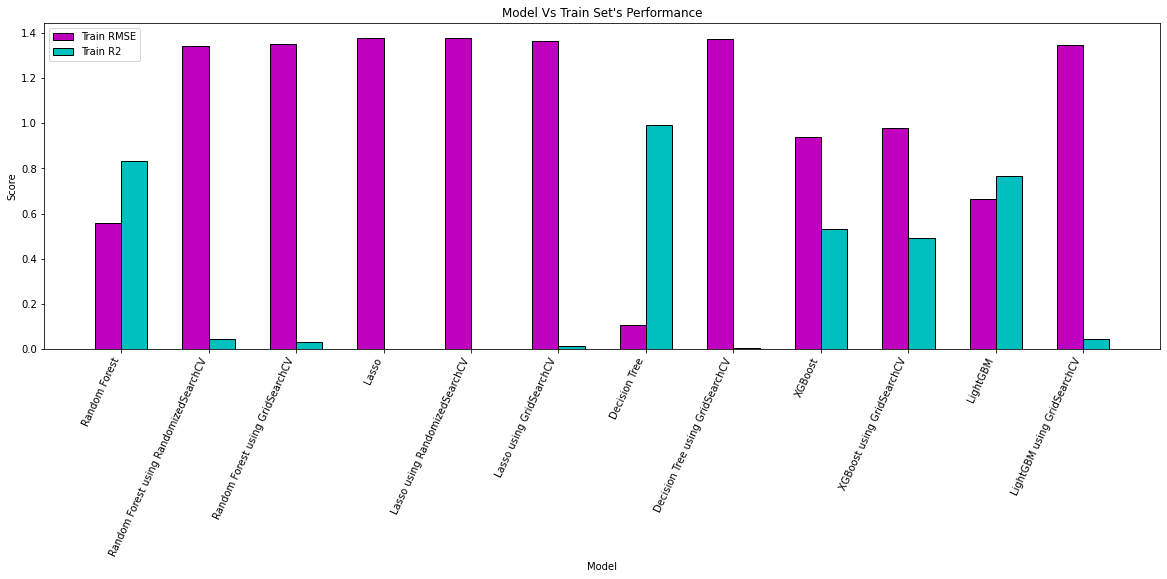

In [146]:
# Plotting graph to compare train set scores

plt.figure(figsize = [20, 6])
r = np.arange(12)
plt.bar(r, result['RMSE_Train'], color = 'm', width = 0.30, edgecolor = 'black', label = 'Train RMSE')
plt.bar(r + 0.30, result['R2_Train'], color = 'c', width = 0.30, edgecolor = 'black', label = 'Train R2')
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Vs Train Set's Performance")
plt.xticks(r + 0.30/2, result['Model'], rotation = 65, ha = 'right')
plt.legend()
plt.show()

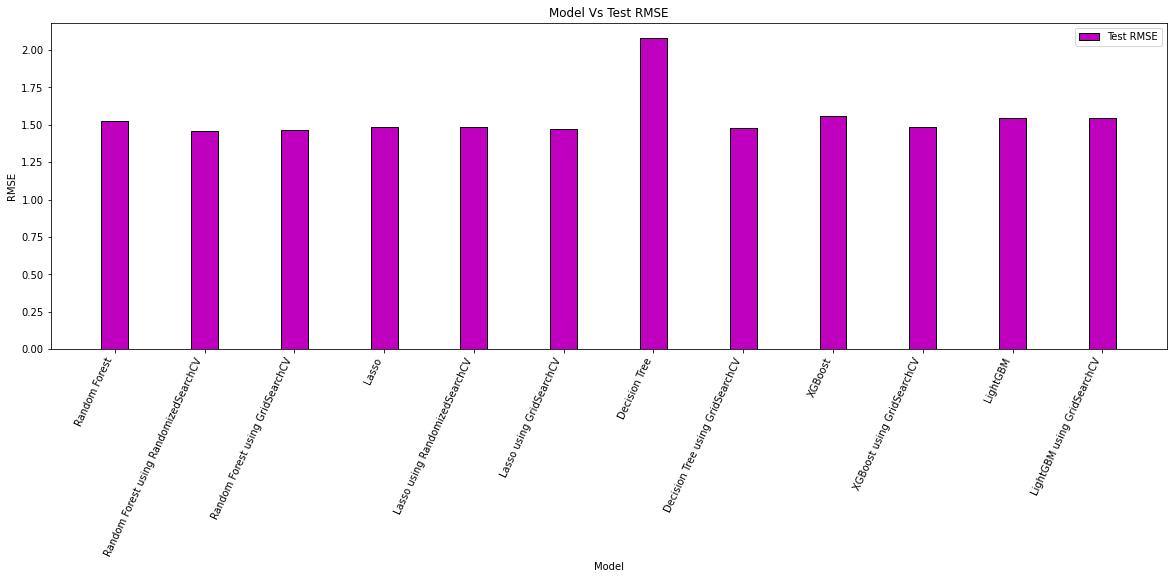

In [147]:
# Plotting graph to compare test set scores

plt.figure(figsize = [20, 6])
plt.bar(r, result['RMSE_Test'], color = 'm', width = 0.30, edgecolor = 'black', label = 'Test RMSE')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model Vs Test RMSE")
plt.xticks(r, result['Model'], rotation = 65, ha = 'right')
plt.legend()
plt.show()